In [1]:
import numpy as np
import gym
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import matplotlib as mpl
from math import exp
mpl.style.use('classic')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.distributions import Categorical, Bernoulli

#from FourRoomsLava import Fourrooms,FourroomsLava
from tworooms import Tworooms
from fourrooms import Fourrooms

In [2]:
env = gym.make('Tworooms-v0')
#env = FourroomsLava()
layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w    Gw
wwwwwwwwwwwww
"""

layout = """\
wwwwwwwwwwwww
w           w
w           w
w           w
w           w
w          Gw
wwwwwwwwwwwww
"""

Occupancy =  [[1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
Observation Space =  Discrete(51)
To state =  {(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4, (1, 7): 5, (1, 8): 6, (1, 9): 7, (1, 10): 8, (1, 11): 9, (2, 1): 10, (2, 2): 11, (2, 3): 12, (2, 4): 13, (2, 5): 14, (2, 7): 15, (2, 8): 16, (2, 9): 17, (2, 10): 18, (2, 11): 19, (3, 1): 20, (3, 2): 21, (3, 3): 22, (3, 4): 23, (3, 5): 24, (3, 6): 25, (3, 7): 26, (3, 8): 27, (3, 9): 28, (3, 10): 29, (3, 11): 30, (4, 1): 31, (4, 2): 32, (4, 3): 33, (4, 4): 34, (4, 5): 35, (4, 7): 36, (4, 8): 37, (4, 9): 38, (4, 10): 39, (4, 11): 40, (5, 1): 41, (5, 2): 42, (5, 3): 43, (5, 4): 44, (5, 5): 45, (5, 7): 46, (5, 8): 47, (5, 9): 48, (5, 10): 49, (5, 11): 50}
To Cell =  {0: (1, 1), 1: (1, 2), 2: (1, 3), 3: (1, 4), 4: (1, 5), 5: (1, 7), 6: (1, 8), 7: (1, 9), 8: (1, 10), 9: (1, 11), 

In [3]:
layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w    Gw
wwwwwwwwwwwww
"""

# View Map

In [4]:
def getEnvLayout(layout,wall_value=20, lava=True, danger=True):
    num_row = 7
    num_col = 13
    line_count = 0
    mat_layout = -2*np.ones((num_row, num_col))
    mapping_state_row_col = defaultdict(list)
    ann_layout = np.zeros((num_row, num_col))
    state_count = 0
    for line in layout.splitlines():
        for i in range(num_col):
            if line[i]!="w":
                mapping_state_row_col[state_count].extend([line_count, i])
                ann_layout[line_count, i] = state_count
                state_count +=1            
            if line[i] == "d" and danger == True:
                mat_layout[line_count, i] = 5
            elif line[i] == "L" and lava == True:
                mat_layout[line_count, i] = 10
            elif line[i]=="w":
                    mat_layout[line_count, i] = 0.5
            elif line[i]=="G":
                    mat_layout[line_count, i] = 0
                    
        line_count +=1

    return mat_layout, ann_layout, mapping_state_row_col

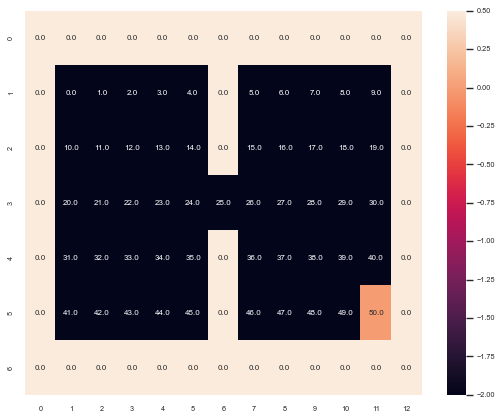

In [5]:
#graphical representation for the environment
plt.figsize=(10, 8)
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
sn.set(font_scale=0.6)
ax = sn.heatmap(mat_layout, annot = ann_layout, fmt = '')
plt.show()
plt.close()

# Models

In [6]:
class StateModel(nn.Module):
    def __init__(self, num_states, num_outputs):
        super(StateModel, self).__init__()
        self.num_states = num_states
        self.num_outputs = num_outputs

        """
        self.features = nn.Sequential(
            nn.Linear(num_states, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU()
        )
        """

        self.features = nn.Sequential(
            nn.Linear(num_states, 32),
            nn.ReLU()
        )


    def forward(self, observation):
        state = self.features(observation)
        return state.detach()

In [7]:
"""

This is the policy over options, the Q function

"""
class PolicyOverOptions(nn.Module):
    def __init__(self, rng, num_states, num_options, eps_start=1.0, eps_min=0.1, eps_decay=int(1e5)):
        super(PolicyOverOptions, self).__init__()
        self.rng = rng
        self.num_states = num_states
        self.num_options = num_options
        #self.epsilon = epsilon

        #self.linear1 = nn.Linear(self.num_states, 64)
        #self.act1 = nn.ReLU()
        #self.linear2 = nn.Linear(64, self.num_states)

        self.eps_min   = eps_min
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.num_steps = 0

        self.linear = nn.Linear(self.num_states, self.num_options)

    def Q_omega(self, state, option=None):
        #return nn.Sequential(self.linear1, self.act1, self.linear2)
        #state = self.linear1(state)
        #state = self.act1(state)
        #state = self.linear2(state)
        return self.linear(state)
        #return state

    def sample_option(self, state):
        #if self.rng.uniform() < self.epsilon:
          #return int(self.rng.randint(self.noptions))
        #else:
        #Q = self.get_Q(state)
        #return Q.argmax(dim=-1).item()
        epsilon = self.epsilon
        e_greedy_option = self.linear(state).argmax(dim=-1).item()
        option = np.random.choice(self.num_options) if np.random.rand() < epsilon else e_greedy_option
        return option
  
    @property
    def epsilon(self):
        eps = self.eps_min + (self.eps_start - self.eps_min) * exp(-self.num_steps / self.eps_decay)
        self.num_steps += 1
        #return eps
        return 0.1


In [8]:
class Termination(nn.Module):
    def __init__(self, num_states, num_options):
        super(Termination, self).__init__()
        self.num_states = num_states
        self.num_options = num_options

        #self.linear1 = nn.Linear(self.num_states, 64)
        #self.act1 = nn.ReLU()
        #self.linear2 = nn.Linear(64, self.num_states)
        #self.sig = nn.Sigmoid()

        self.linear = nn.Linear(self.num_states, self.num_options)

    def terminations(self, state):
        #state = self.linear1(state)
        #state = self.act1(state)
        #state = self.linear2(state).sigmoid()
        #state = self.sig(state)
        state = self.linear(state).sigmoid()
        return state

    def predict_option_termination(self, state, current_option):
        termination = self.linear(state)[current_option].sigmoid()
        #state = self.linear1(state)
        #state = self.act1(state)
        #termination = self.linear2(state).sigmoid()
        option_termination = Bernoulli(termination).sample()
        return bool(option_termination.item())

In [9]:
class SoftmaxPolicy(nn.Module):
    def __init__(self, num_states, num_options, num_actions, temperature=1):
        super(SoftmaxPolicy, self).__init__()
        self.num_states = num_states
        self.num_options = num_options
        self.num_actions = num_actions
        self.temperature = temperature

        self.options_W = nn.Parameter(torch.zeros(num_options, num_states, num_actions))
        self.options_b = nn.Parameter(torch.zeros(num_options, num_actions))

    def sample_action(self, state, option):
        #logits = state[option] @ self.options_W[option] + self.options_b[option]
        logits = state @ self.options_W[option] + self.options_b[option]
        action_dist = (logits / self.temperature).softmax(dim=-1)
        action_dist = Categorical(action_dist)
        
        action  = action_dist.sample()
        logp    = action_dist.log_prob(action)
        entropy = action_dist.entropy()
        return action.item(), logp, entropy

In [10]:
!ls ./

Closed-Loop ELOs
Continuous_Test_NumpyFourRoom.ipynb
Continuous_Test_NumpyTwoRoom-Copy1.ipynb
Continuous_Test_NumpyTwoRoom.ipynb
FourRoomsLava.py
Trained_Models
Trained_Models copy
__pycache__
experience_replay.py
fourrooms.py
logger.py
main.py
option_critic.py
option_critic_split.py
option_critic_split2.py
runs
tworooms.py
utils.py


# Import Model

In [11]:
file_num = 1
state_sd = torch.load("./Trained_Models/TwoRooms/"+ str(file_num) + "/State_model.pt")
policy_sd = torch.load("./Trained_Models/TwoRooms/"+ str(file_num) + "/Policy_over_options.pt")
termination_sd = torch.load("./Trained_Models/TwoRooms/"+ str(file_num) + "/Option_termination.pt")
option_sd = torch.load("./Trained_Models/TwoRooms/"+ str(file_num) + "/Option_policies.pt")

In [12]:
env = gym.make('Tworooms-v0')
num_actions  = env.action_space.n
num_states = env.observation_space.n
num_options = 2

obs = env.reset()
print(len(obs))

state_model = StateModel(num_states, len(obs))
policy_over_options = PolicyOverOptions(123, len(obs), num_options, eps_decay=20000)
option_termination = Termination(len(obs), num_options)
option_policies = SoftmaxPolicy(len(obs), num_options, num_actions)

Occupancy =  [[1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
Observation Space =  Discrete(51)
To state =  {(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4, (1, 7): 5, (1, 8): 6, (1, 9): 7, (1, 10): 8, (1, 11): 9, (2, 1): 10, (2, 2): 11, (2, 3): 12, (2, 4): 13, (2, 5): 14, (2, 7): 15, (2, 8): 16, (2, 9): 17, (2, 10): 18, (2, 11): 19, (3, 1): 20, (3, 2): 21, (3, 3): 22, (3, 4): 23, (3, 5): 24, (3, 6): 25, (3, 7): 26, (3, 8): 27, (3, 9): 28, (3, 10): 29, (3, 11): 30, (4, 1): 31, (4, 2): 32, (4, 3): 33, (4, 4): 34, (4, 5): 35, (4, 7): 36, (4, 8): 37, (4, 9): 38, (4, 10): 39, (4, 11): 40, (5, 1): 41, (5, 2): 42, (5, 3): 43, (5, 4): 44, (5, 5): 45, (5, 7): 46, (5, 8): 47, (5, 9): 48, (5, 10): 49, (5, 11): 50}
To Cell =  {0: (1, 1), 1: (1, 2), 2: (1, 3), 3: (1, 4), 4: (1, 5), 5: (1, 7), 6: (1, 8), 7: (1, 9), 8: (1, 10), 9: (1, 11), 

In [13]:
#state_model.load_state_dict(state_sd)
policy_over_options.load_state_dict(policy_sd)
option_termination.load_state_dict(termination_sd)
option_policies.load_state_dict(option_sd)

<All keys matched successfully>

# Visualize Runs

In [14]:
print(env.tocell)

{0: (1, 1), 1: (1, 2), 2: (1, 3), 3: (1, 4), 4: (1, 5), 5: (1, 7), 6: (1, 8), 7: (1, 9), 8: (1, 10), 9: (1, 11), 10: (2, 1), 11: (2, 2), 12: (2, 3), 13: (2, 4), 14: (2, 5), 15: (2, 7), 16: (2, 8), 17: (2, 9), 18: (2, 10), 19: (2, 11), 20: (3, 1), 21: (3, 2), 22: (3, 3), 23: (3, 4), 24: (3, 5), 25: (3, 6), 26: (3, 7), 27: (3, 8), 28: (3, 9), 29: (3, 10), 30: (3, 11), 31: (4, 1), 32: (4, 2), 33: (4, 3), 34: (4, 4), 35: (4, 5), 36: (4, 7), 37: (4, 8), 38: (4, 9), 39: (4, 10), 40: (4, 11), 41: (5, 1), 42: (5, 2), 43: (5, 3), 44: (5, 4), 45: (5, 5), 46: (5, 7), 47: (5, 8), 48: (5, 9), 49: (5, 10), 50: (5, 11)}


init state:  (1, 5, 3)
done
(5, 11, -7)
Mapping Goal
Reward =  1.0  Steps =  13


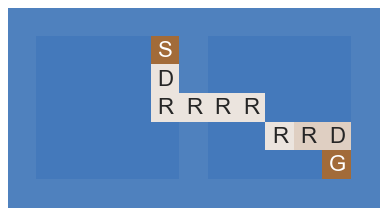

init state:  (4, 9, -4)
done
(5, 11, -7)
Mapping Goal
Reward =  1.0  Steps =  6


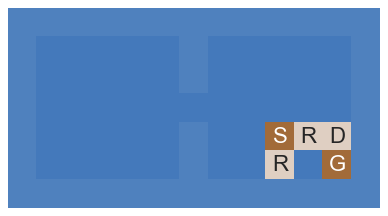

In [40]:
num_rows = 7
num_cols = 13
possible_goal_states = [env.goal]
max_time_step = 20
action_mapping = [u'U',u'D', u'L', u'R']

init_state_done =[]
count_graph_plot = 0
run_to_show = 0 # run number of experiment

start_states =[]
num_traj =2
count_traj = 1
while(count_traj<=num_traj):
    
    curr_time = 0
    obs = env.reset()
    init_state = torch.tensor(obs).float()
    
    if obs in init_state_done:
        continue
    else:
        count_traj +=1
        ann_action = np.chararray((num_rows, num_cols))
        ann_action[:,:] = ''.encode("utf-8")
        init_state_done.append(obs)

    print("init state: ", obs)
    init_obs = obs
    curr_obs = obs
    curr_state = init_state

    options_color = [40, 45,50, 55]
    cmap = sn.diverging_palette(250, 40, sep=20, as_cmap=True)


    goal_state = env.goal
    mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout)
    rewards = 0
    termination = True
    option = np.random.choice([0,1])
    while(env.tostate[(curr_obs[0], curr_obs[1])] != goal_state and max_time_step > curr_time): 
        
        if (termination):
            option = policy_over_options.sample_option(curr_state)
        action, logp, entropy = option_policies.sample_action(curr_state, option)
        
        next_obs, reward, done, info = env.step(action)
        rewards += reward
        next_state = torch.tensor(next_obs).float()
        #print("Curr State = ", curr_state, " Action = ", action, " Next State = ", next_state)
        row, col = mapping_state_row_col[env.tostate[(curr_obs[0], curr_obs[1])]]
        mat_layout[row, col] = options_color[option]
        
        if (done):
            print("done")
            ann_action[row, col] = action_mapping[action].encode("utf-8")
            curr_obs = next_obs
            curr_state = next_state
            curr_time +=1
            break

        
        if curr_obs == init_obs:
            ann_action[row,col] = 'S'.encode("utf-8")
            mat_layout[row,col] = 70
        else:
            ann_action[row, col] = action_mapping[action].encode("utf-8")
        curr_obs = next_obs
        curr_state = next_state
        curr_time +=1
        termination = option_termination.predict_option_termination(curr_state, option)

    if env.tostate[(curr_obs[0], curr_obs[1])] == goal_state:
        print(curr_obs)
        print("Mapping Goal")
        r,c = mapping_state_row_col[env.tostate[(curr_obs[0], curr_obs[1])]]
        mat_layout[r,c] = 70
        ann_action[r,c] = 'G'.encode("utf-8")
    print("Reward = ", rewards, " Steps = ", curr_time)
    plt.figure(figsize = (6,6))
    sn.set(font_scale=0.6)
    ax = sn.heatmap(mat_layout, annot = ann_action.decode(), fmt = '', cmap=cmap, cbar=False,annot_kws={"size": 20},square=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    init_state_done.append(init_obs)
    count_graph_plot +=1
    plt.show()
    plt.close()

# Visualize Action Policies per Option

Done with option  0
Done with option  1
Option  0


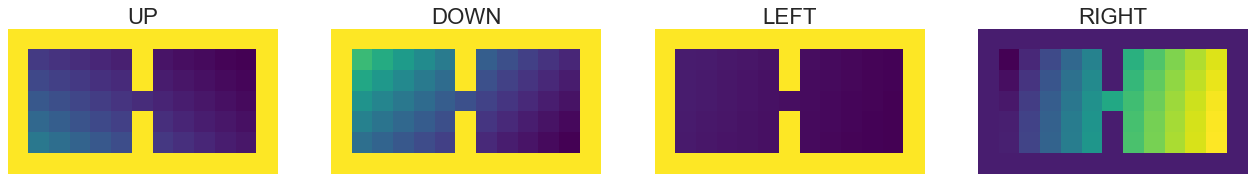

Option  1


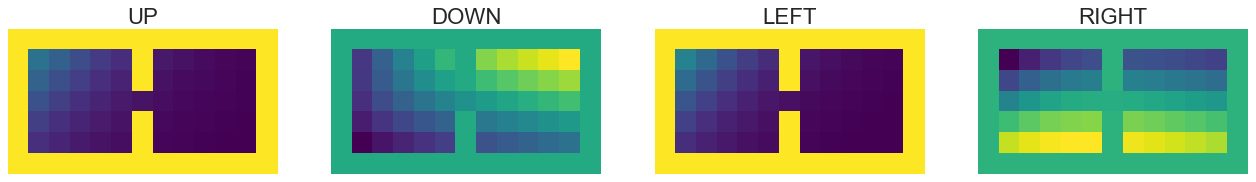

In [16]:
count_graph_plot = 0
run_to_show = 0 # run number of experiment

num_options = 2
#init_states = env.init_states
init_states = list(range(env.observation_space.n))
    
up_probs = []
down_probs = []
right_probs = []
left_probs = []
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
W = option_policies.options_W
b = option_policies.options_b

for option in range(0, num_options):
    up_temp = np.copy(mat_layout)
    down_temp = np.copy(mat_layout)
    right_temp = np.copy(mat_layout)
    left_temp = np.copy(mat_layout)
    for obs in init_states:

        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()

        logits = state @ W[option] + b[option]
        action_dist = (logits /1).softmax(dim=-1)
        action_dist = Categorical(action_dist)

        probs = action_dist.probs
        #print("State = ", state, " Probs = ", probs)
        
        row, col = mapping_state_row_col[obs]
        up_temp[row, col] =  probs[0]
        down_temp[row, col] =  probs[1]
        left_temp[row, col] =  probs[2]
        right_temp[row, col] =  probs[3]
        
    up_probs.append(up_temp)
    down_probs.append(down_temp)
    right_probs.append(right_temp)
    left_probs.append(left_temp)
    print("Done with option ", option)


for i in range(num_options):
    print("Option ", i)
    fix, axs = plt.subplots(1,4, figsize=(20, 20))
    sn.set(font_scale=0.6)
    #plt.figure(figsize=(5,5))
    sn.heatmap(up_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[0], xticklabels=False, yticklabels=False)
    sn.heatmap(down_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[1], xticklabels=False, yticklabels=False)
    sn.heatmap(left_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[2], xticklabels=False, yticklabels=False)
    sn.heatmap(right_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[3], xticklabels=False, yticklabels=False)
    axs[0].set_title('UP', fontsize=20)
    axs[1].set_title('DOWN', fontsize=20)
    axs[2].set_title('LEFT', fontsize=20)
    axs[3].set_title('RIGHT', fontsize=20)
    plt.show()
    plt.close()

Done with getting aggregate action


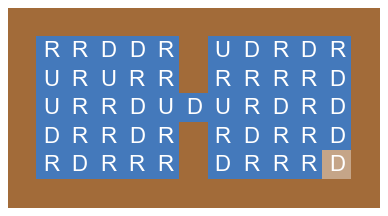

In [29]:
actions = []
action_mapping = [u'U',u'D', u'L', u'R']
mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)
ann_action = np.chararray((7, 13))
#ann_action = np.copy(mat_layout)
#ann_action[:,:] = ''.encode("utf-8")
options_color = [40, 45,50, 55]
cmap = sn.diverging_palette(250, 40, sep=20, as_cmap=True)
for obs in init_states:
    state_arr = env.tocell[obs]
    state = env.states[(state_arr[0], state_arr[1])]
    state = torch.tensor(state).float()

    temp = []
    """
    for i in range(num_options):
        action, logp, entropy = option_policies.sample_action(state, i)
        actions.append(action)
        temp.append(action)
    val = np.array(temp).argmax()
    """
    option = policy_over_options.sample_option(state)
    action, logp, entropy = option_policies.sample_action(state, option)
    val = action
    row, col = mapping_state_row_col[obs]
    ann_action[row, col] = action_mapping[val].encode("utf-8")

print("Done with getting aggregate action")

def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

plt.figure(figsize = (6,6))
sn.set(font_scale=0.6)
ax = sn.heatmap(mat_layout, annot = ann_action.decode(), fmt = '', cmap=cmap, cbar=False,annot_kws={"size": 20},square=True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

# Visualize Termination/Option Switches

Option  0


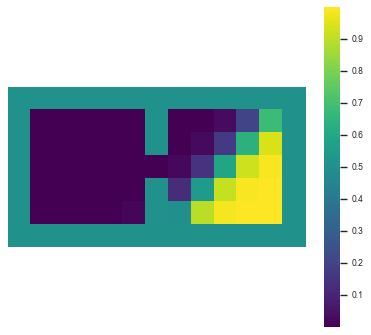

Option  1


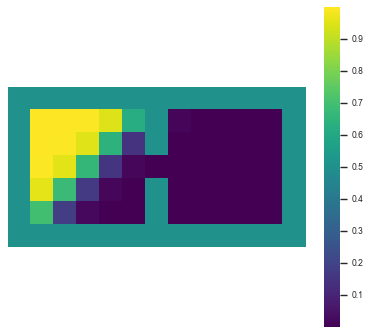

In [18]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

init_states = list(range(env.observation_space.n))
for option in range(num_options):
    mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)
    print ("Option ",option)    
    fig, ax = plt.subplots(figsize=(6, 5))
    for obs in init_states:
        r, c = mapping_state_row_col[obs]
        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()
        termination = option_termination.terminations(state).detach().numpy()
        #print(termination)
        option_termination_val = termination[option]
        #print(termination)
        #print(option_termination_val)
        mat_layout[r,c] = termination[option].item()
        #ann_layout[r,c] = round(termination[option],2)
        
    sn.set(font_scale=0.7)
    #ax = sn.heatmap(mat_layout, annot = np.round(ann_layout,2), fmt = '', cmap="YlGnBu", cbar = True, square=True)
    ax = sn.heatmap(mat_layout, fmt = '', cmap="viridis", cbar = True, square=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#     plt.savefig((os.path.join(path,"IOC_FinalBeta_O"+ str(option) +".png")), dpi=200, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches='tight', pad_inches=0,
#                 frameon=None, figsize=(5, 5))
    plt.show()
    plt.close()

Option  0
Option  1
(2, 7, 13)
[[5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
  5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
  5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
  5.00000000e-01]
 [5.00000000e-01 1.07147036e-09 9.11658837e-09 7.75684796e-08
  6.59989723e-07 5.61548859e-06 5.00000000e-01 4.06367966e-04
  3.44706024e-03 2.85893325e-02 2.00263217e-01 6.80574894e-01
  5.00000000e-01]
 [5.00000000e-01 7.53768958e-09 6.41344258e-08 5.45685907e-07
  4.64294908e-06 3.95031566e-05 5.00000000e-01 2.85176514e-03
  2.37555727e-02 1.71528801e-01 6.37893856e-01 9.37455952e-01
  5.00000000e-01]
 [5.00000000e-01 5.30269126e-08 4.51178835e-07 3.83883844e-06
  3.26617810e-05 2.77834595e-04 2.35903333e-03 1.97224878e-02
  1.46163836e-01 5.92920959e-01 9.25333261e-01 9.90605414e-01
  5.00000000e-01]
 [5.00000000e-01 3.73039057e-07 3.17399076e-06 2.70052533e-05
  2.29727608e-04 1.95126969e-03 5.00000000e-01 1.23988330e-01
  5.46335101e-01 9.11083698e-

IndexError: index 2 is out of bounds for axis 0 with size 2

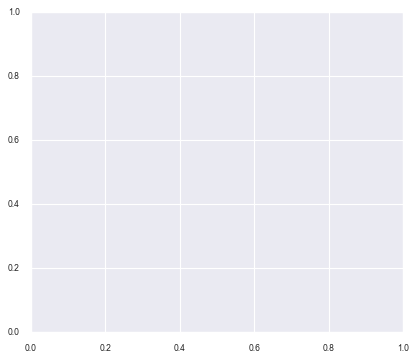

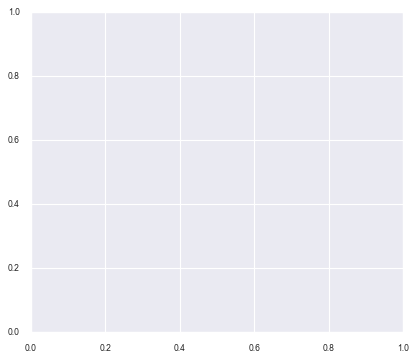

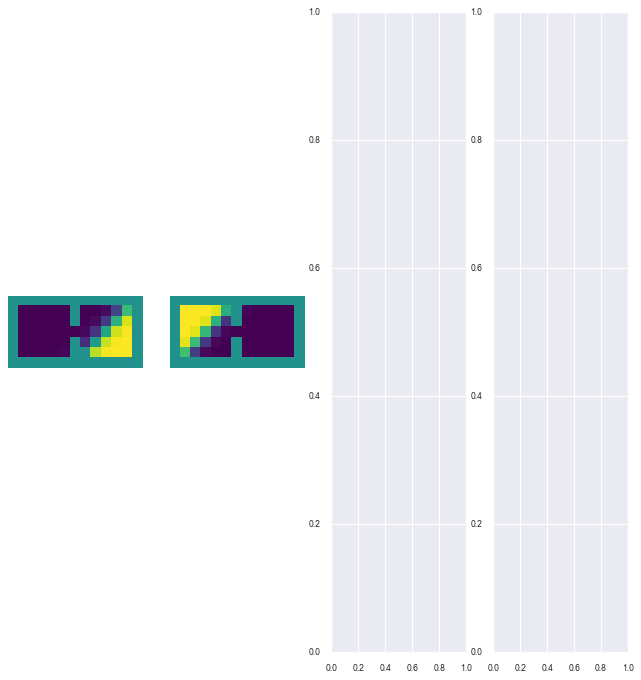

In [19]:
init_states = list(range(env.observation_space.n))
probs = []
for option in range(num_options):
    mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)
    print ("Option ",option)    
    fig, ax = plt.subplots(figsize=(6, 5))
    temp = []
    for obs in init_states:
        r, c = mapping_state_row_col[obs]
        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()

        termination = option_termination.terminations(state)
        option_termination_val = Bernoulli(termination).sample()
        #print(termination)
        #print(option_termination_val)
        mat_layout[r,c] = termination[option].item()
        temp.append(termination[option].item())
        #ann_layout[r,c] = round(termination[option],2)
    temp = np.array(temp)
    probs.append(mat_layout)
        
probs = np.array(probs).squeeze()
print(np.array(probs).shape)
print(np.array(probs[0]))
fix, axs = plt.subplots(1,4, figsize=(10, 10))
sn.set(font_scale=0.7)
#ax = sn.heatmap(mat_layout, annot = np.round(ann_layout,2), fmt = '', cmap="YlGnBu", cbar = True, square=True)
sn.heatmap(probs[0], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[0], xticklabels=False, yticklabels=False)
sn.heatmap(probs[1], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[1], xticklabels=False, yticklabels=False)
sn.heatmap(probs[2], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[2], xticklabels=False, yticklabels=False)
sn.heatmap(probs[3], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[3], xticklabels=False, yticklabels=False)
axs[0].set_title('Option 0', fontsize=15)
axs[1].set_title('Option 1', fontsize=15)
axs[2].set_title('Option 2', fontsize=15)
axs[3].set_title('Option 3', fontsize=15)
plt.show()
plt.show()
plt.close()

In [ ]:
# 1) See the update values in the continuoous vs tabular case (look at gradieents and see if they match). Get the exact state representation for both (manually take an action and see if they match)
# 2) Put a negative reward for each time step
# 3) Recreate the original tabular OC
# 4) check code for errors

In [ ]:
# 1) Negative Rewards
# 2) State Representation: Poosition of agent, position of nearest danger, relative distance between them, sine and cosine of angle between them